In [56]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
import logging
from pyspark.sql.functions import col, sum as pyspark_sum, countDistinct
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import numpy as np
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, unix_timestamp, hour, dayofmonth, month, year, to_timestamp

# Create SparkSession
spark = SparkSession.builder \
                    .appName('a4pt4') \
                    .getOrCreate()

In [2]:
# Importing datasets as pyspark dataframe
df = spark.read.format("csv") \
             .option("header", "true") \
             .option("inferSchema", "true") \
             .load("joined04.csv")

### balance classes

In [3]:
# Count the number of instances for each class
class_counts = df.groupBy("music_effects").count().collect()
class_counts_dict = {row['music_effects']: row['count'] for row in class_counts}

# Calculate the maximum class count
max_count = max(class_counts_dict.values())

# Define a function to balance the classes
def balance_classes(df, class_counts, max_count):
    sampled_dfs = []
    for cls, count in class_counts.items():
        if count < max_count:
            fraction = max_count / count
            sampled_df = df.filter(col("music_effects") == cls).sample(withReplacement=True, fraction=fraction, seed=42)
        else:
            sampled_df = df.filter(col("music_effects") == cls)
        sampled_dfs.append(sampled_df)
    return sampled_dfs

# Apply the function to balance the classes
sampled_dfs = balance_classes(df, class_counts_dict, max_count)
balanced_df = sampled_dfs[0]
for sampled_df in sampled_dfs[1:]:
    balanced_df = balanced_df.union(sampled_df)

# Verify the class distribution
balanced_df.groupBy("music_effects").count().show()

+-------------+-----+
|music_effects|count|
+-------------+-----+
|            1|  524|
|            3|  546|
|            2|  542|
+-------------+-----+



In [4]:
# Split the balanced data into training and test sets of 80/70
train_df, test_df = balanced_df.randomSplit([0.8, 0.2])

In [5]:
from pyspark.ml.feature import StringIndexer

# List of categorical columns to be indexed
categorical_columns = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']

# Apply StringIndexer to each categorical column
indexers = [StringIndexer(inputCol=column, outputCol=column + "_indexed").fit(train_df) for column in categorical_columns]

# Apply the indexers to the data
for indexer in indexers:
    train_df = indexer.transform(train_df)
    test_df = indexer.transform(test_df)


24/05/23 16:57:49 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
# Assemble features
from pyspark.ml.feature import VectorAssembler

# Define the feature columns, including indexed categorical columns
indexed_feature_columns = [column + "_indexed" for column in categorical_columns]
feature_columns = [col for col in df.columns if col not in ["music_effects", "unique_id", "timestamp", "primary_streaming_service", "fav_genre", "age_bin", "hours_per_day_bin", "date"]]
all_feature_columns = feature_columns + indexed_feature_columns

# Assemble features into a vector
assembler = VectorAssembler(inputCols=all_feature_columns, outputCol="features")
assembled_train_df = assembler.transform(train_df)
assembled_test_df = assembler.transform(test_df)


+--------------------+--------------------+
|             Feature|          Importance|
+--------------------+--------------------+
|                 age| 0.06974397782556455|
|       hours_per_day|0.025105938131145717|
|       while_working|0.015394188849801925|
|                 bpm|0.033702806761998626|
| frequency_classical|0.018046237426917053|
|       frequency_edm|0.017206631106492364|
|      frequency_folk|0.012569489745022778|
|   frequency_hip_hop| 0.02030600602907475|
|     frequency_k_pop|0.014668632534443882|
|     frequency_latin| 0.02400958931664215|
|      frequency_lofi| 0.01463393736941205|
|     frequency_metal|0.024244694817012354|
|       frequency_pop|0.014339816760348251|
|       frequency_r&b|0.020400106660679374|
|      frequency_rock| 0.01562155673091182|
|frequency_video_g...| 0.01896755452941571|
|             anxiety| 0.04548115727848281|
|          depression| 0.12888820010794436|
|            insomnia|0.022551935727659175|
|                 ocd|0.02226860

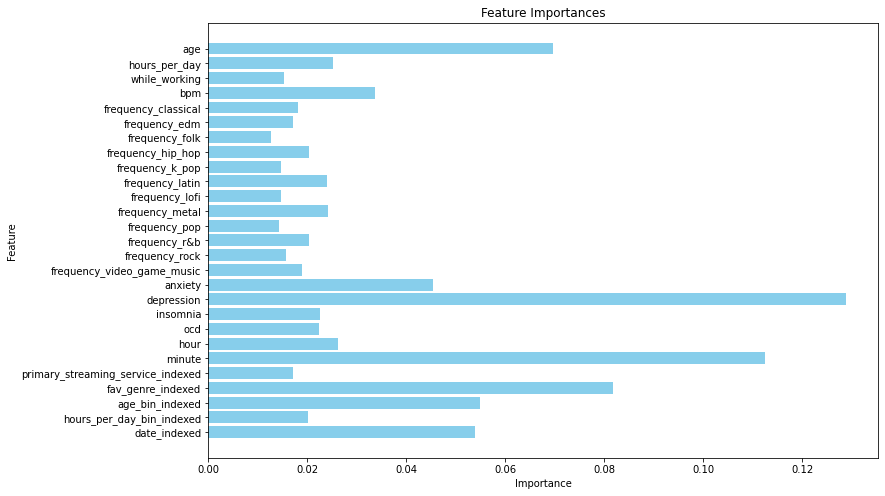

In [7]:
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt

# Define a RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100, maxBins=50)

# Train the model
rf_model = rf.fit(assembled_train_df)

# Get feature importances
importances = rf_model.featureImportances

# Get feature names
feature_names = assembler.getInputCols()

# Combine feature names and importances into a list of tuples, converting importances to float
data = [(feature, float(importance)) for feature, importance in zip(feature_names, importances.toArray())]

# Create a PySpark DataFrame
importance_df = spark.createDataFrame(data, ["Feature", "Importance"])

# Filter features with importance greater than 0.01
important_features_df = importance_df.filter(col("Importance") > 0.01)

# Show the information on the new dataset
important_features_df.show()

# Convert PySpark DataFrame to Pandas DataFrame
importance_pdf = important_features_df.toPandas()

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_pdf["Feature"], importance_pdf["Importance"], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()


In [8]:
# Extracted features into new dataframe
# List of important features to extract
important_features = [
    "age", "hours_per_day", "while_working", "bpm", "frequency_classical",
    "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin",
    "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b",
    "frequency_rock", "frequency_video_game_music", "anxiety", "depression",
    "insomnia", "ocd", "hour", "minute", "primary_streaming_service",
    "fav_genre", "age_bin", "hours_per_day_bin", "date"
]

# Add music_effects to the list of important features
important_features.append("music_effects")

# Extract the important features from the original DataFrame
extracted_df = df.select(*important_features)
# Print schema to understand the structure
extracted_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- hours_per_day: double (nullable = true)
 |-- while_working: integer (nullable = true)
 |-- bpm: double (nullable = true)
 |-- frequency_classical: integer (nullable = true)
 |-- frequency_edm: integer (nullable = true)
 |-- frequency_folk: integer (nullable = true)
 |-- frequency_hip_hop: integer (nullable = true)
 |-- frequency_latin: integer (nullable = true)
 |-- frequency_lofi: integer (nullable = true)
 |-- frequency_metal: integer (nullable = true)
 |-- frequency_pop: integer (nullable = true)
 |-- frequency_r&b: integer (nullable = true)
 |-- frequency_rock: integer (nullable = true)
 |-- frequency_video_game_music: integer (nullable = true)
 |-- anxiety: double (nullable = true)
 |-- depression: double (nullable = true)
 |-- insomnia: double (nullable = true)
 |-- ocd: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- primary_streaming_service: string (nullable = true)
 |-- fav

In [9]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Save DataFrame as CSV") \
    .getOrCreate()

# Save the DataFrame as a CSV file
file_path = "4extracted_df.csv"
extracted_df.write.mode("overwrite").option("header", "true").csv(file_path)

# Show the file path
print("CSV file saved at:", file_path)

CSV file saved at: 4extracted_df.csv


In [15]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Save and Read DataFrame as CSV") \
    .getOrCreate()

# Assuming extracted_df is already defined and you want to save it
file_path = "4extracted_df.csv"

# Save the DataFrame as a CSV file
extracted_df.write.mode("overwrite").option("header", "true").csv(file_path)

# Show the file path
print("CSV file saved at:", file_path)

# Read the CSV file back into a Spark DataFrame
extracted_df = spark.read.option("header", "true").csv(file_path)

# Show the schema and first few rows of the read-back DataFrame
extracted_df.printSchema()



AnalysisException: Unable to infer schema for CSV. It must be specified manually.

In [ ]:
# Visualise distributions of selected features 
import matplotlib.pyplot as plt

# Convert the PySpark DataFrame to a Pandas DataFrame for visualization
pandas_df = df.select(important_features).toPandas()

# Plot histograms of the features
pandas_df.hist(figsize=(20, 15), bins=50)
plt.show()


In [ ]:
import pandas as pd
from pyspark.sql.functions import col, log, sqrt
from pyspark.sql import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Function to calculate skewness and kurtosis
def calculate_statistics(df: DataFrame, columns: list) -> pd.DataFrame:
    stats = {}
    for column in columns:
        col_data = df.select(col(column)).toPandas()
        stats[column] = {
            'skewness': skew(col_data.dropna()),
            'kurtosis': kurtosis(col_data.dropna())
        }
    return pd.DataFrame(stats).T

# New features df
df = extracted_df
# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Ensure all columns are correctly transformed
def transform_columns(df: DataFrame, transformation_func, suffix: str) -> DataFrame:
    transformed_cols = [transformation_func(col(c)).alias(f"{c}_{suffix}") for c in df.columns if c not in string_cols + ['music_effects']]
    return df.select(['music_effects'] + [f"{col}_indexed" for col in string_cols] + transformed_cols)

# Apply log and sqrt transformations
df_log_transformed = transform_columns(df_indexed, lambda c: log(c + 1), 'log')
df_sqrt_transformed = transform_columns(df_indexed, sqrt, 'sqrt')

# Extract relevant columns for comparison
numeric_columns = [col for col in df.columns if col not in string_cols + ['music_effects']]
original_stats = calculate_statistics(df_indexed, numeric_columns)
log_stats = calculate_statistics(df_log_transformed, [f"{col}_log" for col in numeric_columns])
sqrt_stats = calculate_statistics(df_sqrt_transformed, [f"{col}_sqrt" for col in numeric_columns])

# Print statistics
print("Original Data Statistics:")
print(original_stats)
print("\nLog-Transformed Data Statistics:")
print(log_stats)
print("\nSquare Root-Transformed Data Statistics:")
print(sqrt_stats)



In [ ]:
import pandas as pd
from pyspark.sql.functions import col, log, sqrt
from pyspark.sql import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, boxcox, yeojohnson
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Function to calculate skewness and kurtosis
def calculate_statistics(df: DataFrame, columns: list) -> pd.DataFrame:
    stats = {}
    for column in columns:
        col_data = df.select(col(column)).toPandas()
        stats[column] = {
            'skewness': skew(col_data.dropna()),
            'kurtosis': kurtosis(col_data.dropna())
        }
    return pd.DataFrame(stats).T

# New features df
df = extracted_df
# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Ensure all columns are correctly transformed
def transform_columns(df: DataFrame, transformation_func, suffix: str) -> DataFrame:
    transformed_cols = [transformation_func(col(c)).alias(f"{c}_{suffix}") for c in df.columns if c not in string_cols + ['music_effects']]
    return df.select(['music_effects'] + [f"{col}_indexed" for col in string_cols] + transformed_cols)

# Apply log and sqrt transformations
df_log_transformed = transform_columns(df_indexed, lambda c: log(c + 1), 'log')
df_sqrt_transformed = transform_columns(df_indexed, sqrt, 'sqrt')

# Apply Box-Cox and Yeo-Johnson transformations
def apply_statistical_transformation(df: DataFrame, columns: list, method='boxcox') -> pd.DataFrame:
    pandas_df = df.select(columns).toPandas()
    transformed_data = pd.DataFrame()
    for column in columns:
        if method == 'boxcox':
            transformed_data[f"{column}_boxcox"] = boxcox(pandas_df[column] + 1)[0]  # boxcox requires positive values
        elif method == 'yeojohnson':
            transformed_data[f"{column}_yeojohnson"] = yeojohnson(pandas_df[column] + 1)[0]
    return spark.createDataFrame(transformed_data)
numeric_columns = [col for col in df.columns if col not in string_cols + ['music_effects']]
boxcox_transformed_df = apply_statistical_transformation(df_indexed, numeric_columns, method='boxcox')
yeojohnson_transformed_df = apply_statistical_transformation(df_indexed, numeric_columns, method='yeojohnson')

# Calculate statistics for Box-Cox and Yeo-Johnson transformations
boxcox_stats = calculate_statistics(boxcox_transformed_df, [f"{col}_boxcox" for col in numeric_columns])
yeojohnson_stats = calculate_statistics(yeojohnson_transformed_df, [f"{col}_yeojohnson" for col in numeric_columns])

# Print statistics
print("Original Data Statistics:")
print(original_stats)
print("\nLog-Transformed Data Statistics:")
print(log_stats)
print("\nSquare Root-Transformed Data Statistics:")
print(sqrt_stats)
print("\nBox-Cox Transformed Data Statistics:")
print(boxcox_stats)
print("\nYeo-Johnson Transformed Data Statistics:")
print(yeojohnson_stats)

# Function to visualize distributions before and after transformations
def plot_distributions(original_df, transformed_df, transformation_name):
    for column in numeric_columns:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(original_df.select(col(column)).toPandas().dropna(), kde=True)
        plt.title(f'Original: {column}')
        plt.subplot(1, 2, 2)
        sns.histplot(transformed_df.select(col(f"{column}_{transformation_name}")).toPandas().dropna(), kde=True)
        plt.title(f'{transformation_name}: {column}')
        plt.show()

# Plot distributions
plot_distributions(df_indexed, df_log_transformed, 'log')
plot_distributions(df_indexed, df_sqrt_transformed, 'sqrt')
plot_distributions(df_indexed, boxcox_transformed_df, 'boxcox')
plot_distributions(df_indexed, yeojohnson_transformed_df, 'yeojohnson')


In [ ]:
import pandas as pd
from pyspark.sql.functions import col, log1p, sqrt
from pyspark.sql import DataFrame
from pyspark.sql.types import DoubleType
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson, skew, kurtosis
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Function to calculate skewness and kurtosis
def calculate_statistics(df: DataFrame, columns: list) -> pd.DataFrame:
    stats = {}
    for column in columns:
        col_data = df.select(col(column)).toPandas()
        stats[column] = {
            'skewness': skew(col_data.dropna()),
            'kurtosis': kurtosis(col_data.dropna())
        }
    return pd.DataFrame(stats).T

# Function to apply Yeo-Johnson transformation
def apply_yeojohnson(df: DataFrame, columns: list) -> DataFrame:
    pandas_df = df.select(columns).toPandas()
    transformed_data = pd.DataFrame()
    for column in columns:
        transformed_data[f"{column}_yeojohnson"] = yeojohnson(pandas_df[column])[0]
    return spark.createDataFrame(transformed_data)

# Ensure numeric columns are of DoubleType for transformations
df = extracted_df
df = df.withColumn("age", col("age").cast(DoubleType()))\
       .withColumn("hours_per_day", col("hours_per_day").cast(DoubleType()))\
       .withColumn("bpm", col("bpm").cast(DoubleType()))\
       .withColumn("frequency_classical", col("frequency_classical").cast(DoubleType()))\
       .withColumn("frequency_edm", col("frequency_edm").cast(DoubleType()))\
       .withColumn("frequency_folk", col("frequency_folk").cast(DoubleType()))\
       .withColumn("frequency_hip_hop", col("frequency_hip_hop").cast(DoubleType()))\
       .withColumn("frequency_latin", col("frequency_latin").cast(DoubleType()))\
       .withColumn("frequency_lofi", col("frequency_lofi").cast(DoubleType()))\
       .withColumn("frequency_metal", col("frequency_metal").cast(DoubleType()))\
       .withColumn("frequency_pop", col("frequency_pop").cast(DoubleType()))\
       .withColumn("frequency_r&b", col("frequency_r&b").cast(DoubleType()))\
       .withColumn("frequency_rock", col("frequency_rock").cast(DoubleType()))\
       .withColumn("frequency_video_game_music", col("frequency_video_game_music").cast(DoubleType()))\
       .withColumn("anxiety", col("anxiety").cast(DoubleType()))\
       .withColumn("depression", col("depression").cast(DoubleType()))\
       .withColumn("insomnia", col("insomnia").cast(DoubleType()))\
       .withColumn("ocd", col("ocd").cast(DoubleType()))

# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Ensure all columns are correctly transformed
def transform_columns(df: DataFrame, transformation_func, suffix: str) -> DataFrame:
    transformed_cols = [transformation_func(col(c)).alias(f"{c}_{suffix}") for c in df.columns if c not in string_cols + ['music_effects']]
    return df.select(['music_effects'] + [f"{col}_indexed" for col in string_cols] + transformed_cols)

# Apply log1p and sqrt transformations
df_log1p_transformed = transform_columns(df_indexed, log1p, 'log1p')
df_sqrt_transformed = transform_columns(df_indexed, sqrt, 'sqrt')

# Apply Yeo-Johnson transformation
yeojohnson_transformed_df = apply_yeojohnson(df_indexed, numeric_columns)

# Combine the transformed columns
transformed_df = df_log1p_transformed.join(df_sqrt_transformed, "music_effects", "outer")
transformed_df = transformed_df.join(yeojohnson_transformed_df, "music_effects", "outer")

# Ensure to add back the indexed string columns and music_effects
transformed_df = df_indexed.select(['music_effects'] + [f"{col}_indexed" for col in string_cols]).join(transformed_df, "music_effects", "outer")

# Extract relevant columns for comparison
numeric_columns = [col for col in df.columns if col not in string_cols + ['music_effects']]
original_stats = calculate_statistics(df_indexed, numeric_columns)
log1p_stats = calculate_statistics(df_log1p_transformed, [f"{col}_log1p" for col in numeric_columns])
sqrt_stats = calculate_statistics(df_sqrt_transformed, [f"{col}_sqrt" for col in numeric_columns])
yeojohnson_stats = calculate_statistics(yeojohnson_transformed_df, [f"{col}_yeojohnson" for col in numeric_columns])

# Print statistics
print("Original Data Statistics:")
print(original_stats)
print("\nLog1p-Transformed Data Statistics:")
print(log1p_stats)
print("\nSquare Root-Transformed Data Statistics:")
print(sqrt_stats)
print("\nYeo-Johnson Transformed Data Statistics:")
print(yeojohnson_stats)

In [12]:
#4.2 transformation
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType, IntegerType
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import yeojohnson, boxcox, skew, kurtosis
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

# Function to calculate skewness and kurtosis
def calculate_statistics(df, columns):
    stats = {}
    for column in columns:
        col_data = df.select(col(column)).toPandas()
        stats[column] = {
            'skewness': skew(col_data.dropna()),
            'kurtosis': kurtosis(col_data.dropna())
        }
    return pd.DataFrame(stats).T

# Function to apply Yeo-Johnson transformation
def apply_yeojohnson(df, columns):
    pandas_df = df.select(columns + ['music_effects']).toPandas()
    transformed_data = pd.DataFrame()
    transformed_data['music_effects'] = pandas_df['music_effects']
    for column in columns:
        transformed_data[f"{column}_yeojohnson"] = yeojohnson(pandas_df[column])[0]
    return spark.createDataFrame(transformed_data)

# Function to apply Box-Cox transformation
def apply_boxcox(df, columns):
    pandas_df = df.select(columns + ['music_effects']).toPandas()
    transformed_data = pd.DataFrame()
    transformed_data['music_effects'] = pandas_df['music_effects']
    for column in columns:
        transformed_data[f"{column}_boxcox"], _ = boxcox(pandas_df[column] + 1)  # Adding 1 to ensure all values are positive
    return spark.createDataFrame(transformed_data)

# Ensure numeric columns are of DoubleType for transformations
df = extracted_df
df = df.withColumn("age", col("age").cast(DoubleType()))\
       .withColumn("hours_per_day", col("hours_per_day").cast(DoubleType()))\
       .withColumn("bpm", col("bpm").cast(DoubleType()))\
       .withColumn("frequency_classical", col("frequency_classical").cast(DoubleType()))\
       .withColumn("frequency_edm", col("frequency_edm").cast(DoubleType()))\
       .withColumn("frequency_folk", col("frequency_folk").cast(DoubleType()))\
       .withColumn("frequency_hip_hop", col("frequency_hip_hop").cast(DoubleType()))\
       .withColumn("frequency_latin", col("frequency_latin").cast(DoubleType()))\
       .withColumn("frequency_lofi", col("frequency_lofi").cast(DoubleType()))\
       .withColumn("frequency_metal", col("frequency_metal").cast(DoubleType()))\
       .withColumn("frequency_pop", col("frequency_pop").cast(DoubleType()))\
       .withColumn("frequency_r&b", col("frequency_r&b").cast(DoubleType()))\
       .withColumn("frequency_rock", col("frequency_rock").cast(DoubleType()))\
       .withColumn("frequency_video_game_music", col("frequency_video_game_music").cast(DoubleType()))\
       .withColumn("anxiety", col("anxiety").cast(IntegerType()))\
       .withColumn("depression", col("depression").cast(IntegerType()))\
       .withColumn("insomnia", col("insomnia").cast(IntegerType()))\
       .withColumn("ocd", col("ocd").cast(IntegerType()))\
       .withColumn("music_effects", col("music_effects").cast(IntegerType()))

# List of string columns to be indexed
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
# Initialize StringIndexer for each string column with handleInvalid='keep'
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Apply StringIndexer to transform string columns into indexed columns
pipeline_indexer = Pipeline(stages=indexers)
df_indexed = pipeline_indexer.fit(df).transform(df)

# Apply Yeo-Johnson transformation to the relevant numeric columns
numeric_columns = [col for col in df.columns if col not in string_cols + ['music_effects', 'hours_per_day', 'bpm']]
yeojohnson_transformed_df = apply_yeojohnson(df_indexed, numeric_columns)

# Apply Box-Cox transformation to hours_per_day and bpm
boxcox_transformed_df = apply_boxcox(df_indexed, ['hours_per_day', 'bpm'])

# Calculate statistics
original_stats = calculate_statistics(df_indexed, numeric_columns + ['hours_per_day', 'bpm'])
yeojohnson_stats = calculate_statistics(yeojohnson_transformed_df, [f"{col}_yeojohnson" for col in numeric_columns])
boxcox_stats = calculate_statistics(boxcox_transformed_df, ['hours_per_day_boxcox', 'bpm_boxcox'])

# Print statistics
print("Original Data Statistics:")
print(original_stats)
print("\nYeo-Johnson Transformed Data Statistics:")
print(yeojohnson_stats)
print("\nBox-Cox Transformed Data Statistics:")
print(boxcox_stats)

# Concatenate statistics dataframes
combined_stats = pd.concat([original_stats, yeojohnson_stats, boxcox_stats], axis=1)

# Print combined statistics
print("Combined Statistics:")
print(combined_stats)



Original Data Statistics:
                                           skewness                kurtosis
age                            [1.8895857044177138]    [3.6057917718498285]
while_working                 [-1.4126448280440336]  [-0.00443458980044209]
frequency_classical           [0.20584697166393687]   [-0.9837042719813489]
frequency_edm                  [0.5950379557774494]   [-0.9230320719250535]
frequency_folk                 [0.5988432284183117]   [-0.8154313530521917]
frequency_hip_hop              [0.0876266545078173]   [-1.1425673133392718]
frequency_latin                [1.2665004966342674]    [0.5939484932438441]
frequency_lofi                 [0.4968070382788795]   [-0.9731223155493645]
frequency_metal                [0.3831478025447569]   [-1.2720957706799887]
frequency_pop                 [-0.6336414089562802]   [-0.5574416487122815]
frequency_r&b                 [0.28379711011024733]    [-1.163480028265298]
frequency_rock                [-0.8235623678229196]   [-0.5425

### 4.2 joining back the transfomed data together 

In [17]:
# Concatenate statistics dataframes
combined_stats = pd.concat([original_stats, yeojohnson_stats, boxcox_stats], axis=1)

# Join the transformed dataframes with the original dataframe
combined_transformed_df = extracted_df

# Rename columns to remove suffixes
for column in numeric_columns:
    combined_transformed_df = combined_transformed_df.withColumn(column, col(column))
for column in ['hours_per_day', 'bpm']:
    combined_transformed_df = combined_transformed_df.withColumn(column, col(column))

# Include string columns
for column in string_cols:
    combined_transformed_df = combined_transformed_df.withColumn(column, col(column))

# Show the combined transformed dataframe with the selected columns
#combined_transformed_df.show()

# Print the schema of the combined transformed dataframe
combined_transformed_df.printSchema()



+---+-------------+-------------+-----+-------------------+-------------+--------------+-----------------+---------------+--------------+---------------+-------------+-------------+--------------+--------------------------+-------+----------+--------+---+----+------+-------------------------+----------------+-------+-----------------+----------+-------------+
|age|hours_per_day|while_working|  bpm|frequency_classical|frequency_edm|frequency_folk|frequency_hip_hop|frequency_latin|frequency_lofi|frequency_metal|frequency_pop|frequency_r&b|frequency_rock|frequency_video_game_music|anxiety|depression|insomnia|ocd|hour|minute|primary_streaming_service|       fav_genre|age_bin|hours_per_day_bin|      date|music_effects|
+---+-------------+-------------+-----+-------------------+-------------+--------------+-----------------+---------------+--------------+---------------+-------------+-------------+--------------+--------------------------+-------+----------+--------+---+----+------+---------

# 6

In [30]:
#RandomForest
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Index string columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Assemble features into a vector
feature_columns = [col for col in combined_transformed_df.columns if col not in string_cols + ['music_effects']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the RandomForest model
rf = RandomForestClassifier(labelCol="music_effects", featuresCol="features", numTrees=100)

# Create the pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)

# Train the model
rf_model = pipeline.fit(train_df)

# Make predictions
predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Random Forest Accuracy: {accuracy}")


Random Forest Accuracy: 0.7521367521367521


In [47]:
#Multinomnial logistic regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
import pandas as pd

# List of feature columns
feature_columns = ["age", "hours_per_day", "while_working", "bpm", "frequency_classical", 
                   "frequency_edm", "frequency_folk", "frequency_hip_hop", "frequency_latin", 
                   "frequency_lofi", "frequency_metal", "frequency_pop", "frequency_r&b", 
                   "frequency_rock", "frequency_video_game_music", "anxiety", "depression", 
                   "insomnia", "ocd", "hour", "minute"]

# Index and encode string columns
string_cols = ['primary_streaming_service', 'fav_genre', 'age_bin', 'hours_per_day_bin', 'date']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_indexed", outputCol=f"{col}_vec") for col in string_cols]

# Assemble all features into a single vector
assembler = VectorAssembler(inputCols=feature_columns + [f"{col}_vec" for col in string_cols], outputCol="features")
# Define the Logistic Regression model
lr = LogisticRegression(labelCol="music_effects", featuresCol="features", maxIter=100, family="multinomial")
# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])
# Train-test split
train_df, test_df = combined_transformed_df.randomSplit([0.8, 0.2], seed=42)
# Train the model
lr_model = pipeline.fit(train_df)
# Make predictions
predictions = lr_model.transform(test_df)
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="music_effects", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Multinomial Logistic Regression Accuracy: {accuracy}")
# Extract coefficients and intercepts
coefficient_matrix = lr_model.stages[-1].coefficientMatrix
intercept_vector = lr_model.stages[-1].interceptVector

# Get input columns after one-hot encoding
assembler_features = assembler.getInputCols()

# Verify the shape of the coefficient matrix
print(f"Shape of coefficient matrix: {coefficient_matrix.toArray().shape}")

# Create a list of feature names
expanded_feature_columns = []
for col in feature_columns:
    expanded_feature_columns.append(col)
for col in string_cols:
    # We need to know the actual number of categories for each column
    one_hot_size = train_df.select(f"{col}_vec").head()[f"{col}_vec"].size
    for i in range(one_hot_size):
        expanded_feature_columns.append(f"{col}_vec_{i}")
# Verify the length of expanded feature columns
print(f"Number of expanded feature columns: {len(expanded_feature_columns)}")
# Ensure the number of columns match
assert coefficient_matrix.toArray().shape[1] == len(expanded_feature_columns)
# Create DataFrame of coefficients for each feature and each class
coefficients_df = pd.DataFrame(coefficient_matrix.toArray(), columns=expanded_feature_columns)
coefficients_df['class'] = range(coefficient_matrix.toArray().shape[0])
coefficients_df = coefficients_df.melt(id_vars=['class'], var_name='Feature', value_name='Coefficient')

print("Feature Coefficients:")
print(coefficients_df)



Multinomial Logistic Regression Accuracy: 0.6581196581196581
Shape of coefficient matrix: (4, 113)


AnalysisException: cannot resolve 'primary_streaming_service_vec' given input columns: [age, age_bin, anxiety, bpm, date, depression, fav_genre, frequency_classical, frequency_edm, frequency_folk, frequency_hip_hop, frequency_latin, frequency_lofi, frequency_metal, frequency_pop, frequency_r&b, frequency_rock, frequency_video_game_music, hour, hours_per_day, hours_per_day_bin, insomnia, minute, music_effects, ocd, primary_streaming_service, while_working];
'Project ['primary_streaming_service_vec]
+- Sample 0.0, 0.8, false, 42
   +- Sort [age#6581 ASC NULLS FIRST, hours_per_day#7113 ASC NULLS FIRST, while_working#6609 ASC NULLS FIRST, bpm#7141 ASC NULLS FIRST, frequency_classical#6637 ASC NULLS FIRST, frequency_edm#6665 ASC NULLS FIRST, frequency_folk#6693 ASC NULLS FIRST, frequency_hip_hop#6721 ASC NULLS FIRST, frequency_latin#6749 ASC NULLS FIRST, frequency_lofi#6777 ASC NULLS FIRST, frequency_metal#6805 ASC NULLS FIRST, frequency_pop#6833 ASC NULLS FIRST, frequency_r&b#6861 ASC NULLS FIRST, frequency_rock#6889 ASC NULLS FIRST, frequency_video_game_music#6917 ASC NULLS FIRST, anxiety#6945 ASC NULLS FIRST, depression#6973 ASC NULLS FIRST, insomnia#7001 ASC NULLS FIRST, ocd#7029 ASC NULLS FIRST, hour#7057 ASC NULLS FIRST, minute#7085 ASC NULLS FIRST, primary_streaming_service#7169 ASC NULLS FIRST, fav_genre#7197 ASC NULLS FIRST, age_bin#7225 ASC NULLS FIRST, ... 3 more fields], false
      +- Project [age#6581, hours_per_day#7113, while_working#6609, bpm#7141, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#6973, insomnia#7001, ocd#7029, hour#7057, minute#7085, primary_streaming_service#7169, fav_genre#7197, age_bin#7225, ... 3 more fields]
         +- Project [age#6581, hours_per_day#7113, while_working#6609, bpm#7141, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#6973, insomnia#7001, ocd#7029, hour#7057, minute#7085, primary_streaming_service#7169, fav_genre#7197, age_bin#7225, ... 3 more fields]
            +- Project [age#6581, hours_per_day#7113, while_working#6609, bpm#7141, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#6973, insomnia#7001, ocd#7029, hour#7057, minute#7085, primary_streaming_service#7169, fav_genre#7197, age_bin#48 AS age_bin#7225, ... 3 more fields]
               +- Project [age#6581, hours_per_day#7113, while_working#6609, bpm#7141, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#6973, insomnia#7001, ocd#7029, hour#7057, minute#7085, primary_streaming_service#7169, fav_genre#23 AS fav_genre#7197, age_bin#48, ... 3 more fields]
                  +- Project [age#6581, hours_per_day#7113, while_working#6609, bpm#7141, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#6973, insomnia#7001, ocd#7029, hour#7057, minute#7085, primary_streaming_service#18 AS primary_streaming_service#7169, fav_genre#23, age_bin#48, ... 3 more fields]
                     +- Project [age#6581, hours_per_day#7113, while_working#6609, bpm#26 AS bpm#7141, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#6973, insomnia#7001, ocd#7029, hour#7057, minute#7085, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                        +- Project [age#6581, hours_per_day#19 AS hours_per_day#7113, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#6973, insomnia#7001, ocd#7029, hour#7057, minute#7085, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                           +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#6973, insomnia#7001, ocd#7029, hour#7057, minute#52 AS minute#7085, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                              +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#6973, insomnia#7001, ocd#7029, hour#51 AS hour#7057, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                 +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#6973, insomnia#7001, ocd#46 AS ocd#7029, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                    +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#6973, insomnia#45 AS insomnia#7001, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                       +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#6945, depression#44 AS depression#6973, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                          +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#6917, anxiety#43 AS anxiety#6945, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                             +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#6889, frequency_video_game_music#42 AS frequency_video_game_music#6917, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#6861, frequency_rock#41 AS frequency_rock#6889, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                   +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#6833, frequency_r&b#39 AS frequency_r&b#6861, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                      +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#6805, frequency_pop#38 AS frequency_pop#6833, frequency_r&b#39, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                         +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#6777, frequency_metal#37 AS frequency_metal#6805, frequency_pop#38, frequency_r&b#39, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                            +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#6749, frequency_lofi#36 AS frequency_lofi#6777, frequency_metal#37, frequency_pop#38, frequency_r&b#39, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                               +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#6721, frequency_latin#35 AS frequency_latin#6749, frequency_lofi#36, frequency_metal#37, frequency_pop#38, frequency_r&b#39, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                                  +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#6693, frequency_hip_hop#32 AS frequency_hip_hop#6721, frequency_latin#35, frequency_lofi#36, frequency_metal#37, frequency_pop#38, frequency_r&b#39, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                                     +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#6665, frequency_folk#30 AS frequency_folk#6693, frequency_hip_hop#32, frequency_latin#35, frequency_lofi#36, frequency_metal#37, frequency_pop#38, frequency_r&b#39, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                                        +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#6637, frequency_edm#29 AS frequency_edm#6665, frequency_folk#30, frequency_hip_hop#32, frequency_latin#35, frequency_lofi#36, frequency_metal#37, frequency_pop#38, frequency_r&b#39, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                                           +- Project [age#6581, hours_per_day#19, while_working#6609, bpm#26, frequency_classical#27 AS frequency_classical#6637, frequency_edm#29, frequency_folk#30, frequency_hip_hop#32, frequency_latin#35, frequency_lofi#36, frequency_metal#37, frequency_pop#38, frequency_r&b#39, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                                              +- Project [age#6581, hours_per_day#19, while_working#20 AS while_working#6609, bpm#26, frequency_classical#27, frequency_edm#29, frequency_folk#30, frequency_hip_hop#32, frequency_latin#35, frequency_lofi#36, frequency_metal#37, frequency_pop#38, frequency_r&b#39, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                                                 +- Project [age#17 AS age#6581, hours_per_day#19, while_working#20, bpm#26, frequency_classical#27, frequency_edm#29, frequency_folk#30, frequency_hip_hop#32, frequency_latin#35, frequency_lofi#36, frequency_metal#37, frequency_pop#38, frequency_r&b#39, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                                                    +- Project [age#17, hours_per_day#19, while_working#20, bpm#26, frequency_classical#27, frequency_edm#29, frequency_folk#30, frequency_hip_hop#32, frequency_latin#35, frequency_lofi#36, frequency_metal#37, frequency_pop#38, frequency_r&b#39, frequency_rock#41, frequency_video_game_music#42, anxiety#43, depression#44, insomnia#45, ocd#46, hour#51, minute#52, primary_streaming_service#18, fav_genre#23, age_bin#48, ... 3 more fields]
                                                                                       +- Relation [unique_id#16,age#17,primary_streaming_service#18,hours_per_day#19,while_working#20,instrumentalist#21,composer#22,fav_genre#23,exploratory#24,foreign_languages#25,bpm#26,frequency_classical#27,frequency_country#28,frequency_edm#29,frequency_folk#30,frequency_gospel#31,frequency_hip_hop#32,frequency_jazz#33,frequency_k_pop#34,frequency_latin#35,frequency_lofi#36,frequency_metal#37,frequency_pop#38,frequency_r&b#39,... 13 more fields] csv


In [33]:
# !pip install xgboost
#!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [58]:
#Kmeans clustering 
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline

# Index string columns
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed", handleInvalid='keep') for col in string_cols]

# Assemble features into a vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the KMeans model
kmeans = KMeans(featuresCol="features", k=3)

# Create the pipeline
pipeline = Pipeline(stages=indexers + [assembler, kmeans])

# Train the model
kmeans_model = pipeline.fit(combined_transformed_df)

# Make predictions
predictions = kmeans_model.transform(combined_transformed_df)

# Evaluate the model
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"K-Means Silhouette Score: {silhouette}")

Py4JJavaError: An error occurred while calling o13320.fit.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:118)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1512)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.buildReader(CSVFileFormat.scala:103)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues(FileFormat.scala:131)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues$(FileFormat.scala:122)
	at org.apache.spark.sql.execution.datasources.TextBasedFileFormat.buildReaderWithPartitionValues(FileFormat.scala:177)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:426)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:417)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecute(DataSourceScanExec.scala:504)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:184)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:222)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:219)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.doExecute(ObjectHashAggregateExec.scala:88)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:184)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:222)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:219)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.inputRDD$lzycompute(ShuffleExchangeExec.scala:135)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.inputRDD(ShuffleExchangeExec.scala:135)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.mapOutputStatisticsFuture$lzycompute(ShuffleExchangeExec.scala:140)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.mapOutputStatisticsFuture(ShuffleExchangeExec.scala:139)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeLike.$anonfun$submitShuffleJob$1(ShuffleExchangeExec.scala:68)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:222)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:219)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeLike.submitShuffleJob(ShuffleExchangeExec.scala:68)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeLike.submitShuffleJob$(ShuffleExchangeExec.scala:67)
	at org.apache.spark.sql.execution.exchange.ShuffleExchangeExec.submitShuffleJob(ShuffleExchangeExec.scala:115)
	at org.apache.spark.sql.execution.adaptive.ShuffleQueryStageExec.shuffleFuture$lzycompute(QueryStageExec.scala:170)
	at org.apache.spark.sql.execution.adaptive.ShuffleQueryStageExec.shuffleFuture(QueryStageExec.scala:170)
	at org.apache.spark.sql.execution.adaptive.ShuffleQueryStageExec.doMaterialize(QueryStageExec.scala:172)
	at org.apache.spark.sql.execution.adaptive.QueryStageExec.materialize(QueryStageExec.scala:82)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$5(AdaptiveSparkPlanExec.scala:256)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$5$adapted(AdaptiveSparkPlanExec.scala:254)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$getFinalPhysicalPlan$1(AdaptiveSparkPlanExec.scala:254)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.getFinalPhysicalPlan(AdaptiveSparkPlanExec.scala:226)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:365)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:338)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:3715)
	at org.apache.spark.sql.Dataset.$anonfun$collect$1(Dataset.scala:2971)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3706)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3704)
	at org.apache.spark.sql.Dataset.collect(Dataset.scala:2971)
	at org.apache.spark.ml.feature.StringIndexer.countByValue(StringIndexer.scala:204)
	at org.apache.spark.ml.feature.StringIndexer.sortByFreq(StringIndexer.scala:212)
	at org.apache.spark.ml.feature.StringIndexer.fit(StringIndexer.scala:242)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


In [57]:
import matplotlib.pyplot as plt

# Extract features and predictions
features = predictions.select("features").rdd.map(lambda row: row.features.toArray()).collect()
pred_labels = predictions.select("prediction").rdd.map(lambda row: row.prediction).collect()

# Plot clusters
plt.figure(figsize=(10, 6))
for i in range(len(features)):
    plt.scatter(features[i][0], features[i][1], c=pred_labels[i], cmap='viridis')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KMeans Clustering")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


Py4JJavaError: An error occurred while calling o13318.javaToPython.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)

The currently active SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.base/java.lang.Thread.run(Thread.java:829)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:118)
	at org.apache.spark.SparkContext.broadcast(SparkContext.scala:1512)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat.buildReader(CSVFileFormat.scala:103)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues(FileFormat.scala:131)
	at org.apache.spark.sql.execution.datasources.FileFormat.buildReaderWithPartitionValues$(FileFormat.scala:122)
	at org.apache.spark.sql.execution.datasources.TextBasedFileFormat.buildReaderWithPartitionValues(FileFormat.scala:177)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD$lzycompute(DataSourceScanExec.scala:426)
	at org.apache.spark.sql.execution.FileSourceScanExec.inputRDD(DataSourceScanExec.scala:417)
	at org.apache.spark.sql.execution.FileSourceScanExec.doExecute(DataSourceScanExec.scala:504)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:184)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:222)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:219)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.InputAdapter.inputRDD(WholeStageCodegenExec.scala:526)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs(WholeStageCodegenExec.scala:454)
	at org.apache.spark.sql.execution.InputRDDCodegen.inputRDDs$(WholeStageCodegenExec.scala:453)
	at org.apache.spark.sql.execution.InputAdapter.inputRDDs(WholeStageCodegenExec.scala:497)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:50)
	at org.apache.spark.sql.execution.SortExec.inputRDDs(SortExec.scala:132)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:50)
	at org.apache.spark.sql.execution.SampleExec.inputRDDs(basicPhysicalOperators.scala:340)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:50)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:50)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:50)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:50)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:50)
	at org.apache.spark.sql.execution.ProjectExec.inputRDDs(basicPhysicalOperators.scala:50)
	at org.apache.spark.sql.execution.WholeStageCodegenExec.doExecute(WholeStageCodegenExec.scala:750)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:184)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:222)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:219)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:185)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:184)
	at org.apache.spark.sql.Dataset.javaToPython(Dataset.scala:3529)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
